took  sec to finish training

In [1]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import json
file = open("data_file_2L.json", 'r')
json_data = json.load(file)
merged_dict = {}
for dictionary in json_data:
    for key, value in dictionary.items():
        if key not in merged_dict:
            merged_dict[key] = []
        merged_dict[key].append(value)    
file.close()
print(merged_dict.keys())

dict_keys(['date', 'prefix', 'fullName', 'firstName', 'lastName', 'ssn', 'contactNo.', 'email', 'gender', 'streetAddress', 'zipCode', 'city', 'state', 'country'])


In [3]:
# Print predicted labels and confidence scores
def output_pred(x,y):
    for label, score in zip(x, y):
        if label == 0:
            print("The model predicts the input text to be --->Date")
        elif label == 1:
            print("The model predicts the input text to be --->Prefix")
        elif label == 2:
            print("The model predicts the input text to be --->fullName")
        elif label == 3:
            print("The model predicts the input text to be --->firstName")
        elif label == 4:
            print("The model predicts the input text to be --->lastName")
        elif label == 5:
            print("The model predicts the input text to be --->SNN")
        elif label == 6:
            print("The model predicts the input text to be --->ContactNumber")
        elif label == 7:
            print("The model predicts the input text to be --->Email-ID")
        elif label == 8:
            print("The model predicts the input text to be --->Gender")
        elif label == 9:
            print("The model predicts the input text to be --->streetAddress")
        elif label == 10:
            print("The model predicts the input text to be --->zipCode")
        elif label == 11:
            print("The model predicts the input text to be --->City")
        elif label == 12:
            print("The model predicts the input text to be --->State")
        elif label == 13:
            print("The model predicts the input text to be --->Country")
        print("with a confidence score of:", score)

In [4]:
# data
all_texts = [value for values in merged_dict.values() for value in values]

# labels
lengths_list = [len(values) for values in merged_dict.values()]
all_labels=[]
for i in range(0,len(lengths_list)):
    all_labels += [i] * lengths_list[i]
len(all_texts)

2461560

In [5]:
# Tokenizing the texts
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(all_texts)
sequences = tokenizer.texts_to_sequences(all_texts)

In [6]:
# Pading the sequences
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [7]:
# Converting the labels to one-hot encoding
num_classes = len(np.unique(all_labels))
one_hot_labels = to_categorical(all_labels, num_classes=num_classes)

In [8]:
# Calculate the number of data points per label
num_labels = one_hot_labels.shape[1]
num_points_per_label = np.sum(one_hot_labels, axis=0)

# Calculate the number of data points for each set
total_size = np.sum(num_points_per_label)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Create empty arrays to hold the indices for each set
train_indices = []
val_indices = []
test_indices = []

# Loop through each label and divide the indices into the sets
for label in range(num_labels):
    # Get the indices for the current label
    label_indices = np.where(one_hot_labels[:, label] == 1)[0]

    # Shuffle the indices
    np.random.shuffle(label_indices)

    # Divide the indices into the sets
    num_train_points = int(num_points_per_label[label] * 0.6)
    num_val_points = int(num_points_per_label[label] * 0.2)
    num_test_points = num_points_per_label[label] - num_train_points - num_val_points

    train_indices.extend(label_indices[:num_train_points])
    val_indices.extend(label_indices[num_train_points:num_train_points+num_val_points])
    test_indices.extend(label_indices[num_train_points+num_val_points:num_train_points+num_val_points+int(num_test_points)])

# Use the indices to extract the sequences and labels for each set
train_sequences = padded_sequences[np.array(train_indices)]
train_labels = one_hot_labels[np.array(train_indices)]
val_sequences = padded_sequences[np.array(val_indices)]
val_labels = one_hot_labels[np.array(val_indices)]
test_sequences = padded_sequences[np.array(test_indices)]
test_labels = one_hot_labels[np.array(test_indices)]

In [9]:
# Calculating the class weights
class_weights = dict(zip(np.unique(all_labels), compute_class_weight(class_weight = "balanced", classes = np.unique(all_labels), y = all_labels)))

In [10]:
# Building the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64, input_length=max_sequence_length))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
epochs=100
batchsize=64

In [12]:
# Training the model
if len(class_weights) > 0:
    history=model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=epochs, batch_size=batchsize, class_weight=class_weights)
else:
    history=model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=epochs, batch_size=batchsize) 

Epoch 1/100
23078/23078 [==============================] - 141s 6ms/step - loss: 0.2284 - accuracy: 0.9107 - val_loss: 0.1672 - val_accuracy: 0.9330
Epoch 2/100
23078/23078 [==============================] - 139s 6ms/step - loss: 0.1713 - accuracy: 0.9318 - val_loss: 0.1637 - val_accuracy: 0.9341
Epoch 3/100
23078/23078 [==============================] - 140s 6ms/step - loss: 0.1644 - accuracy: 0.9348 - val_loss: 0.1532 - val_accuracy: 0.9387
Epoch 4/100
23078/23078 [==============================] - 142s 6ms/step - loss: 0.1607 - accuracy: 0.9365 - val_loss: 0.1489 - val_accuracy: 0.9417
Epoch 5/100
23078/23078 [==============================] - 145s 6ms/step - loss: 0.1586 - accuracy: 0.9376 - val_loss: 0.1505 - val_accuracy: 0.9414
Epoch 6/100
23078/23078 [==============================] - 145s 6ms/step - loss: 0.1575 - accuracy: 0.9383 - val_loss: 0.1499 - val_accuracy: 0.9418
Epoch 7/100
23078/23078 [==============================] - 143s 6ms/step - loss: 0.1569 - accuracy: 0.9389

23078/23078 [==============================] - 145s 6ms/step - loss: 0.2144 - accuracy: 0.9237 - val_loss: 0.1686 - val_accuracy: 0.9344
Epoch 56/100
23078/23078 [==============================] - 146s 6ms/step - loss: 0.2119 - accuracy: 0.9246 - val_loss: 0.1735 - val_accuracy: 0.9334
Epoch 57/100
23078/23078 [==============================] - 143s 6ms/step - loss: 0.2098 - accuracy: 0.9240 - val_loss: 0.1820 - val_accuracy: 0.9296
Epoch 58/100
23078/23078 [==============================] - 142s 6ms/step - loss: 0.2097 - accuracy: 0.9255 - val_loss: 0.1759 - val_accuracy: 0.9314
Epoch 59/100
23078/23078 [==============================] - 141s 6ms/step - loss: 0.2384 - accuracy: 0.9207 - val_loss: 0.1902 - val_accuracy: 0.9271
Epoch 60/100
23078/23078 [==============================] - 138s 6ms/step - loss: 0.2196 - accuracy: 0.9225 - val_loss: 0.1752 - val_accuracy: 0.9297
Epoch 61/100
23078/23078 [==============================] - 140s 6ms/step - loss: 0.2118 - accuracy: 0.9237 - val

In [13]:
# Save Model and Weights
model.save('CharCNN.h5')
model.save_weights('CharCNN.hdf5')

In [14]:
# Load saved model
model = load_model('CharCNN.h5')

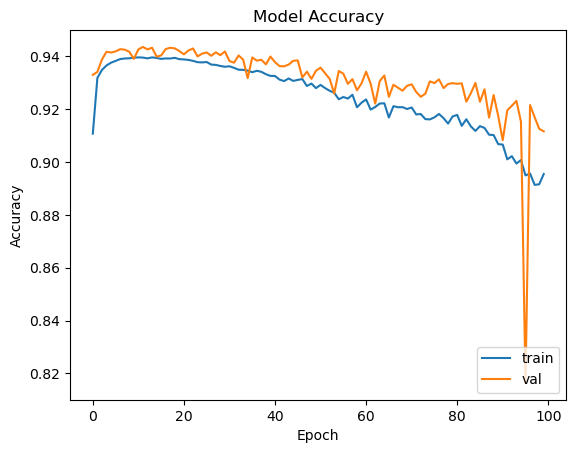

In [15]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

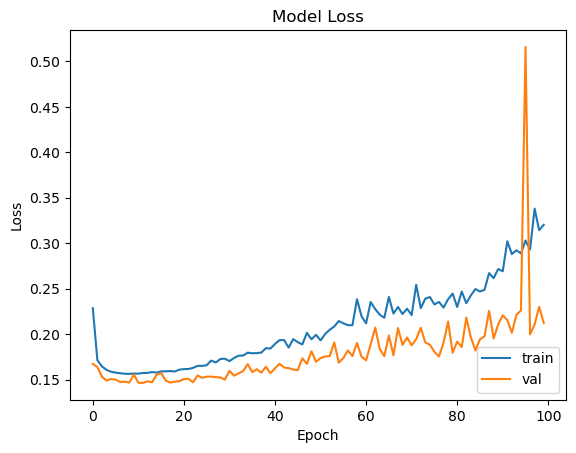

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [17]:
# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_sequences, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

15386/15386 [==============================] - 20s 1ms/step - loss: 0.2123 - accuracy: 0.9115
Test loss: 0.21226947009563446
Test accuracy: 0.9114827513694763


In [18]:
y_pred = model.predict(test_sequences, batch_size=batchsize)

7693/7693 [==============================] - 10s 1ms/step


In [19]:
predicted_labels = np.argmax(y_pred, axis=1)

In [20]:
actual_labels = np.argmax(test_labels, axis=1)

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
# Get the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Print the classification report
print(classification_report(actual_labels, predicted_labels))

# Print the confusion matrix
print("Confusion Matrix:")
print(np.array2string(cm, separator=', '))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40000
           1       0.85      1.00      0.92     37594
           2       0.99      0.99      0.99     33883
           3       0.50      0.86      0.63     33883
           4       0.79      0.17      0.27     33883
           5       1.00      1.00      1.00     29850
           6       1.00      1.00      1.00     27831
           7       1.00      1.00      1.00     37873
           8       0.99      1.00      1.00     40000
           9       1.00      1.00      1.00     21226
          10       1.00      1.00      1.00     38715
          11       0.88      0.91      0.90     38719
          12       0.98      0.86      0.92     39743
          13       1.00      0.97      0.98     39122

    accuracy                           0.91    492322
   macro avg       0.93      0.91      0.90    492322
weighted avg       0.93      0.91      0.90    492322

Confusion Matrix:
[[40000

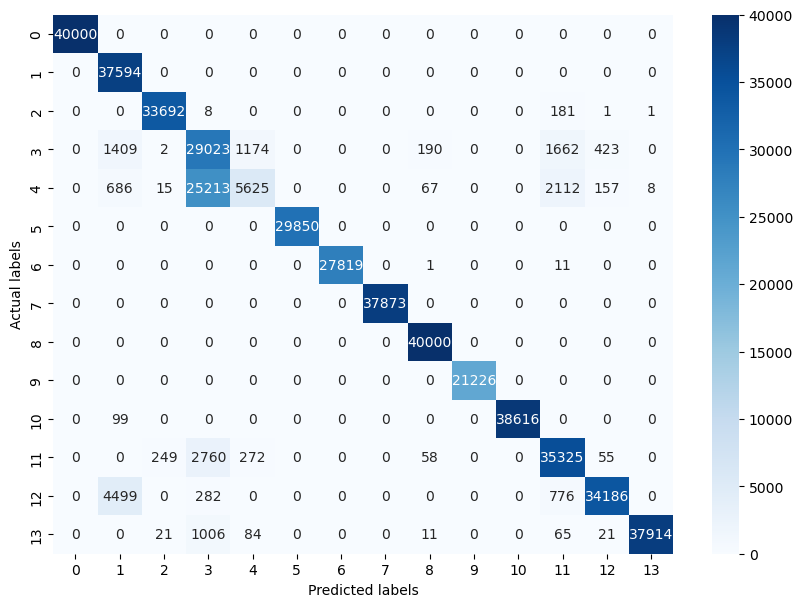

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [23]:
import xlsxwriter

# dictionary mapping labels to their respective text values
label2text = {0: "Date", 1: "Name Prefix", 2: "fullName", 3: "firstName", 4: "lastName", 5: "SNN", 6: "Contact Number", 7: "Email-ID", 8: "Gender", 9: "streetAddress", 10: "zipCode", 11: "City", 12: "State", 13: "Country"}

# Convert numeric class labels to text labels
expected_texts = [label2text[label] for label in actual_labels]
predicted_texts = [label2text[label] for label in predicted_labels]

# Create a new Excel workbook and add a worksheet
workbook = xlsxwriter.Workbook('CharCNNpredictions.xlsx')
worksheet = workbook.add_worksheet()

# Add headers to the worksheet
worksheet.write('A1', 'Input Text')
worksheet.write('B1', 'Expected')
worksheet.write('C1', 'Predicted')

# Write the input text, expected, and predicted values to the worksheet
for i in range(len(test_sequences)):
    input_text = tokenizer.sequences_to_texts([test_sequences[i]])[0]
    expected_value = expected_texts[i]
    predicted_value = predicted_texts[i]
    worksheet.write(i+1, 0, input_text)
    worksheet.write(i+1, 1, expected_value)
    worksheet.write(i+1, 2, predicted_value)

# Close the workbook
workbook.close()

In [24]:
confidence_scores = np.max(y_pred, axis=1)

In [25]:
# Testcase
# 304-353-8783 # phone number
# 828-37-9295 # SNN
# vishal@gmail.com # gmail
# bharath
# texas # state
new_texts = ["vishal@gmail.com"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)

# Make predictions on new texts and calculate confidence scores
predictions = model.predict(new_padded_sequences)
predicted_labels = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)
print(predicted_labels)
output_pred(predicted_labels,confidence_scores)

1/1 [==============================] - 0s 20ms/step
[7]
The model predicts the input text to be --->Email-ID
with a confidence score of: 1.0
